In [668]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

In [669]:
# recipe_df = pd.read_csv('fully_encoded_recipes_with_cuisine_from_SP.csv', index_col=0)
# recipe_df

In [697]:
def cross_validate(data_df, parameters, response_column, num_cv_runs):
    colors = []
    colors = ['black','silver','lightcoral','red','darkorange','gold','olivedrab','lawngreen','darkgreen','aquamarine','teal',
              'cyan','dodgerblue','violet','fuchsia']
    X_raw = data_df.drop(columns = [response_column])
    y_raw = data_df[response_column].values.reshape(-1,1)
    classes_list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
    composite_fpr = []
    composite_tpr = []
    average_roc_auc = []
    roc_auc = dict()
    print(parameters['n_estimators'])
    for i in range(1,num_cv_runs):
        X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw,random_state = 10*i)
        rf_model = RandomForestClassifier(n_estimators=parameters['n_estimators'],
                                          min_samples_split=parameters['min_samples_split'],
                                          min_samples_leaf=parameters['min_samples_leaf'],
                                          max_features=parameters['max_features'],
                                          max_depth=parameters['max_depth'],
                                          random_state = 42)
        rf_model.fit(X_train, np.ravel(y_train))
        y_score = rf_model.predict_proba(X_test)
        y_test_bin = label_binarize(y_test, classes = classes_list)
        n_classes = y_test_bin.shape[1]
        
       
        fpr = dict()
        tpr = dict()
        
        local_roc_auc = []
        for index in range(n_classes):
            fpr[index], tpr[index], thresholds = roc_curve(y_test_bin[:,index], y_score[:, index])
            local_roc_auc.append(roc_auc_score(y_test_bin[:,index], y_score[:, index]))
        composite_fpr.append(fpr)
        composite_tpr.append(tpr)
#         print(composite_fpr)
# Plot out area under curve vs class number           
        
        roc_auc[i] = local_roc_auc   
        average_roc_auc.append
        for item in roc_auc.values():
            
            plt.plot(classes_list, item, color=colors[index], lw=2)
#             plt.plot(fpr[index], tpr[index], color=colors[index], lw=2,label=f'class: {index}')
#             print('AUC for Class {}: {}'.format(index+1, roc_auc_score(fpr[index], tpr[index])))
    plt.xlim([0.0, 15.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('class')
    plt.ylabel('roc_auc')
    plt.title('Area Under Receiver Operating Characteristic Curves')
    plt.show()
# Plot out ROC curves

#     print(composite_fpr[0])

    for index in range(0, len(composite_fpr)):
       
#         print(composite_tpr[index])
#         print('***********************************')
#         print(composite_fpr[index])
#         print('++++++++++++++++++++++++++++++++++++')
        for i in range(0,len(composite_fpr[index])):
            plt.plot(composite_fpr[index][i],composite_tpr[index][i], color=colors[i], lw=2)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curves')
    plt.show()
    
    average = []
    for index in range(1, len(roc_auc)+1):
        total = 0
        for element in roc_auc[index]:
            total = total + element
        average.append(total/15)
    counter = [x for x in range(len(average))]
    print(counter)
    plt.plot(counter, average)
    
    return roc_auc

In [694]:
def call_grid_search (data_df, random_st):
    X_raw = data_df.drop(columns='cuisine_SP')
    y_raw = data_df['cuisine_SP'].values.reshape(-1,1)
    X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, random_state = random_st)
    rfc_model = RandomForestClassifier()
    
    
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}
    # Random search of parameters
    rf_random = RandomizedSearchCV(estimator = rfc_model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, 
                                   random_state=random_st, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(X_train, np.ravel(y_train))
    best_params = dict()
    best_params = rf_random.best_params_
    return best_params

In [695]:
parameters_to_run = call_grid_search(recipe_df,  42)
# parameters_to_run

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [696]:
print(parameters_to_run)

{'n_estimators': 1200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 90}


1200


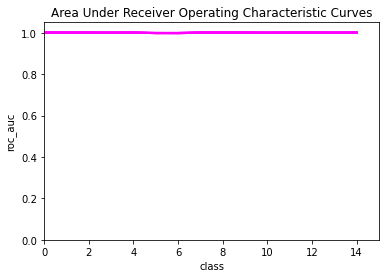

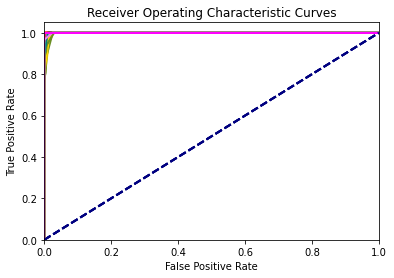

[0, 1, 2, 3]


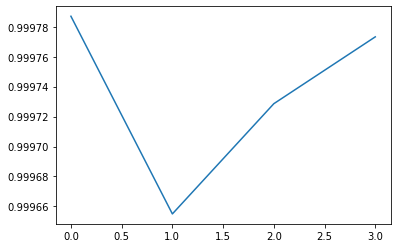

In [699]:
roc_auc_out = dict()
roc_auc_out = cross_validate(recipe_df, parameters_to_run, 'cuisine_SP', 5)
# print(roc_auc_to_plot)

In [705]:
X_raw = recipe_df.drop(columns='cuisine_SP')
y_raw = recipe_df['cuisine_SP'].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, random_state = 42)
rf_tuned = RandomForestClassifier(n_estimators=parameters_to_run['n_estimators'],
                                    min_samples_split=parameters_to_run['min_samples_split'],
                                    min_samples_leaf=parameters_to_run['min_samples_leaf'],
                                    max_features=parameters_to_run['max_features'],
                                    max_depth=parameters_to_run['max_depth'],
                                    random_state = 42)
rf_tuned.fit(X_train, np.ravel(y_train))
y_test_predicted = rf_tuned.predict(X_test)
cm_tuned = confusion_matrix(y_test, y_test_predicted)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm_tuned, index=["Actual 0", "Actual 1","Actual 2","Actual 3","Actual 4","Actual 5","Actual 6","Actual 7","Actual 8","Actual 9",
               "Actual 10","Actual 11","Actual 12","Actual 13","Actual 14"], 
    columns=["Predicted 0", "Predicted 1","Predicted 2","Predicted 3","Predicted 4","Predicted 5","Predicted 6","Predicted 7",
             "Predicted 8","Predicted 9","Predicted 10","Predicted 11","Predicted 12","Predicted 13","Predicted 14",])
    
cm_df


,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7,Predicted 8,Predicted 9,Predicted 10,Predicted 11,Predicted 12,Predicted 13,Predicted 14
Actual 0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Actual 1,0,166,0,0,0,0,0,0,0,0,0,0,0,0,0
Actual 2,0,0,82,0,0,0,0,0,0,0,0,0,0,0,0
Actual 3,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0
Actual 4,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0
Actual 5,0,0,0,0,0,9,0,0,0,0,5,0,0,0,0
Actual 6,0,0,0,2,0,0,25,0,0,0,3,0,0,2,0
Actual 7,0,0,0,0,0,0,0,15,0,0,0,0,0,0,0
Actual 8,0,0,0,0,0,0,0,0,45,0,0,0,0,0,0
Actual 9,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0


In [709]:
print(classification_report(y_test, y_test_predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00       166
           2       1.00      1.00      1.00        82
           3       0.80      1.00      0.89         8
           4       1.00      1.00      1.00        16
           5       1.00      0.64      0.78        14
           6       1.00      0.78      0.88        32
           7       1.00      1.00      1.00        15
           8       1.00      1.00      1.00        45
           9       1.00      1.00      1.00        14
          10       0.92      1.00      0.96       125
          11       1.00      1.00      1.00       110
          12       1.00      1.00      1.00        15
          13       0.98      0.97      0.97        89
          14       1.00      1.00      1.00         2

    accuracy                           0.98       738
   macro avg       0.98      0.96      0.97       738
weighted avg       0.98   